**update 14.08:**
1. New features were added: Hic, disorder, CUB (updated), TF (transcription factors), target features (in the past they were part of the CUB table). 
2. In previous version, we removed from 'full_table' the genes with more than **10%** missing values. Now I changed the threshold such that genes with more than **5%** missing values are filtered. 

**update 22.09:** 

1. New Target Gene Features (Bar) - longest common string, and profile features (GC content, mRNA folding, Codon and AA usage). 
2. New conservation features (Hadar) - conservation and entropy. 
3. Because the new entropy features include many missing values (only 4700 genes are in the table) , and because they are still significant for the learning, we decided to increase the threshold and remove genes with more than 10% missing values. 
4. After the above filtering, the remaining tables is filtered again and features are removed if they have more than 600 missing values (used to be 1000). 

In [1]:
import pandas as pd
import numpy as np
from os import chdir
import matplotlib.pyplot as plt

In [2]:
directory = r'/home/karinsio/my_project_dir/iGEM/Merge_Features'
chdir(directory)

In [3]:
## load all feature tables and set their index to 'ORF' (change the name of column if needed)
old_features_df = pd.read_csv(r'Not_normalized_table.csv', index_col='ORF') #updated features from 10-genes project. 
bar_df = pd.read_csv(r'final table with nan1.csv', index_col='ORF') #SGD, LFE, co-expression, ATG-context, shifted-ORF.
bar_df_HiC = pd.read_csv(r'HiC.csv', index_col='ORF').rename(columns={'Rank':'Rank_HiC'}) #HiC data - NEW July
noa_df_biogrid = pd.read_excel(r'biogrid final.xlsx').rename(columns={'Systematic name ':'ORF'}).set_index('ORF')
noa_df_yeastmine = pd.read_excel(r'yeastmine.xlsx').rename(columns={'BioEntity.secondaryIdentifier':'ORF'}).set_index('ORF')
noa_df_disorder = pd.read_excel(r'disorder_output.xlsx').rename(columns={'gene name':'ORF'}).set_index('ORF') #new August
karin_df = pd.read_excel(r'CUB_results_final.xlsx', index_col='ORF') #codon usage bias
hadar_df = pd.read_csv(r'not_normalized_smf_dmf_ranks_feature.csv').rename(columns={'genes':'ORF'}).set_index('ORF') #cellmap
hadar_df_tfs = pd.read_csv(r'number_of_TF.csv',index_col='ORF') #transcription factors (TFs) - NEW July
hadar_df_conservation = pd.read_csv(r'conservation features gene names converted.csv',index_col='ORF') #conservation - NEW SEPTEMBER
hadar_df_entropy = pd.read_csv(r'entropy features gene names converted.csv',index_col='ORF') # entropy (part of conservation) - NEW SEPTEMBER

In [4]:
## load the target gene features of GFP. Attention: for a NEW target gene, these columns will be replaced in order to
# perform 'transfer learning' of the GFP-trained model to the new target gene. 
target_gene_GFP_df = pd.read_excel(r'Target_gene_df_GFP_updated.xlsx', index_col='ORF') #GFP (22.09: now include CAI, RCA, longest common string, and profile features.). 
#in the future, it will include ChimeraARS score (bar is working on it). 
target_gene_GFP_df = target_gene_GFP_df.drop(['Unnamed: 0'],axis=1)

In [5]:
## drop dulpications and unnamed columns
karin_df = karin_df.drop(['ORF.1','Unnamed: 0','mRNA_RPKM'],axis=1) #mRNA_RPKM is a duplication of 'mRNA' from old_features
hadar_df = hadar_df.drop(['Unnamed: 0'],axis=1)
noa_df_disorder = noa_df_disorder.drop(['disorder_percentage1','disorder_percentage2'],axis=1) #duplications of 'disorder_percentage_both_algorithms' column

In [6]:
# Rename repeating features names
old_features_df.rename(columns={'ranks': 'rank_STRING', 'weighted_rank': 'weighted_rank_STRING'}, inplace=True)
hadar_df.rename(columns={'rank': 'rank_TheCellMap','positive_rank': 'positive_rank_TheCellMap',
                        'negative_rank': 'negative_rank_TheCellMap',
                         'positive_weighted_rank': 'positive_weighted_rank_TheCellMap',
                        'negative_weighted_rank': 'negative_weighted_rank_TheCellMap',
                        'absolute_weighted_rank': 'absolute_weighted_rank_TheCellMap'}, inplace=True)


In [7]:
# Deleting 'gene_sequence' and 'BioEntity.name' because it is not numeric
karin_df = karin_df.drop(['gene_sequence'],axis=1);
noa_df_yeastmine = noa_df_yeastmine.drop(['BioEntity.name'],axis=1)

In [8]:
# Joining tables
full_table = old_features_df.join([bar_df, bar_df_HiC, noa_df_biogrid, noa_df_yeastmine, noa_df_disorder, karin_df, hadar_df, hadar_df_tfs,hadar_df_conservation,hadar_df_entropy, target_gene_GFP_df], how = 'left')
# full_table = old_features_df.join([bar_df, bar_df_HiC, noa_df_biogrid, noa_df_yeastmine, noa_df_disorder, karin_df, hadar_df, hadar_df_tfs, target_gene_GFP_df], how = 'left')
full_table.rename_axis('ORF',  inplace = True)
full_table

,gc_content_total,gc_content_1,gc_content_2,gc_content_3,molecular_weight,MeltingPoint_NN,aromaticity,isoelectric_point,helix_perc,turn_perc,...,AAU_neighbors_dist_target_gene_ks_dist,FE_neighbors_dist_target_gene_ks_dist,GC_neighbors_dist_target_gene_cart_d,CU_neighbors_dist_target_gene_cart_d,AAU_neighbors_dist_target_gene_cart_d,FE_neighbors_dist_target_gene_cart_d,GC_neighbors_dist_L1_dist,CU_neighbors_dist_L1_dist,AAU_neighbors_dist_L1_dist,FE_neighbors_dist_L1_dist
ORF,,,,,,,,,,,,,,,,,,,,,
Q0010,23.772610,22.480620,20.930233,27.906977,1.189251e+05,68.756624,0.271318,4.684387,0.689922,0.224806,...,0.285714,0.500000,1.099215,6.882708,0.054669,282.647998,1.437037,11.773242,0.716532,39.940000
Q0017,29.012346,35.185185,24.074074,27.777778,4.970086e+04,68.736876,0.129630,9.895935,0.518519,0.240741,...,0.285714,0.500000,0.983570,6.422266,0.053498,215.253997,1.557037,12.747872,0.735342,34.320000
Q0032,11.340206,9.278351,14.432990,10.309278,8.958672e+04,61.968730,0.247423,9.469543,0.649485,0.164948,...,0.285714,0.500000,1.146844,6.787585,0.054986,286.917998,1.320000,12.610575,0.704781,43.420000
Q0045,29.906542,38.130841,37.196262,14.392523,4.950959e+05,73.508043,0.127103,6.583801,0.431776,0.257944,...,0.142857,0.416667,1.075778,9.387726,0.056127,143.539998,1.400000,12.401977,0.441886,21.960000
Q0050,24.950100,30.898204,32.934132,11.017964,7.769448e+05,71.145017,0.082635,9.887512,0.361677,0.233533,...,0.190476,0.500000,1.047111,9.461169,0.055935,159.681998,1.473333,13.785043,0.461040,23.080000
Q0055,26.510721,31.111111,32.865497,15.555556,7.952377e+05,72.022549,0.092398,9.672668,0.347368,0.250292,...,0.190476,0.416667,1.079111,9.935381,0.056954,171.391998,1.366667,11.687849,0.470365,21.699999
Q0060,21.634615,30.528846,28.365385,6.009615,3.867137e+05,69.507854,0.112981,9.510803,0.379808,0.269231,...,0.190476,0.500000,0.976889,9.716674,0.056144,148.223998,1.606667,13.986812,0.483113,22.100000
Q0065,23.459007,30.879713,31.238779,8.258528,5.171934e+05,70.672292,0.107720,9.644348,0.402154,0.244165,...,0.190476,0.416667,0.999556,9.473032,0.056188,151.477998,1.553333,13.926882,0.511102,22.400000
Q0070,22.873745,30.269414,30.903328,7.448494,5.852550e+05,70.146024,0.118859,9.531433,0.440571,0.247227,...,0.238095,0.416667,0.954667,9.312675,0.057225,157.191997,1.693333,14.251699,0.475611,28.380000


In [9]:
# Geting rid of Unnamed columns
full_table.drop(full_table.columns[full_table.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [10]:
full_table.shape

(6720, 1970)

In [11]:
# Deleting 'gene_length' beacuse it is less informative than 'length' column
"""first_length = full_table['gene_length']-----> has 887 NaNs
second_length = full_table['length']-----> has 37 NaNs
"""
del full_table['gene_length']

In [12]:
# Geting rid of features with a lot of missing numbers
full_table.drop(['CAI','dS', 'dN', 'dN/dS', 'dS adjusted', 'dN/dS adjusted', 'Starvation STD'], axis = 1, inplace = True)

In [13]:
full_table.shape

(6720, 1962)

In [14]:
full_table.index.drop_duplicates(keep='first') #print the size of full_table without duplications in rows.

Index(['Q0010', 'Q0017', 'Q0032', 'Q0045', 'Q0050', 'Q0055', 'Q0060', 'Q0065',
       'Q0070', 'Q0075',
       ...
       'YPR196W', 'YPR197C', 'YPR198W', 'YPR199C', 'YPR200C', 'YPR201W',
       'YPR202W', 'YPR203W', 'YPR204C-A', 'YPR204W'],
      dtype='object', name='ORF', length=6713)

In [15]:
## drop duplications according to 'ORF' column because we used the 'join' metric to combine the tables.
full_table = full_table.reset_index().drop_duplicates(subset='ORF',keep='first').set_index('ORF')

In [16]:
full_table

,gc_content_total,gc_content_1,gc_content_2,gc_content_3,molecular_weight,MeltingPoint_NN,aromaticity,isoelectric_point,helix_perc,turn_perc,...,AAU_neighbors_dist_target_gene_ks_dist,FE_neighbors_dist_target_gene_ks_dist,GC_neighbors_dist_target_gene_cart_d,CU_neighbors_dist_target_gene_cart_d,AAU_neighbors_dist_target_gene_cart_d,FE_neighbors_dist_target_gene_cart_d,GC_neighbors_dist_L1_dist,CU_neighbors_dist_L1_dist,AAU_neighbors_dist_L1_dist,FE_neighbors_dist_L1_dist
ORF,,,,,,,,,,,,,,,,,,,,,
Q0010,23.772610,22.480620,20.930233,27.906977,1.189251e+05,68.756624,0.271318,4.684387,0.689922,0.224806,...,0.285714,0.500000,1.099215,6.882708,0.054669,282.647998,1.437037,11.773242,0.716532,39.940000
Q0017,29.012346,35.185185,24.074074,27.777778,4.970086e+04,68.736876,0.129630,9.895935,0.518519,0.240741,...,0.285714,0.500000,0.983570,6.422266,0.053498,215.253997,1.557037,12.747872,0.735342,34.320000
Q0032,11.340206,9.278351,14.432990,10.309278,8.958672e+04,61.968730,0.247423,9.469543,0.649485,0.164948,...,0.285714,0.500000,1.146844,6.787585,0.054986,286.917998,1.320000,12.610575,0.704781,43.420000
Q0045,29.906542,38.130841,37.196262,14.392523,4.950959e+05,73.508043,0.127103,6.583801,0.431776,0.257944,...,0.142857,0.416667,1.075778,9.387726,0.056127,143.539998,1.400000,12.401977,0.441886,21.960000
Q0050,24.950100,30.898204,32.934132,11.017964,7.769448e+05,71.145017,0.082635,9.887512,0.361677,0.233533,...,0.190476,0.500000,1.047111,9.461169,0.055935,159.681998,1.473333,13.785043,0.461040,23.080000
Q0055,26.510721,31.111111,32.865497,15.555556,7.952377e+05,72.022549,0.092398,9.672668,0.347368,0.250292,...,0.190476,0.416667,1.079111,9.935381,0.056954,171.391998,1.366667,11.687849,0.470365,21.699999
Q0060,21.634615,30.528846,28.365385,6.009615,3.867137e+05,69.507854,0.112981,9.510803,0.379808,0.269231,...,0.190476,0.500000,0.976889,9.716674,0.056144,148.223998,1.606667,13.986812,0.483113,22.100000
Q0065,23.459007,30.879713,31.238779,8.258528,5.171934e+05,70.672292,0.107720,9.644348,0.402154,0.244165,...,0.190476,0.416667,0.999556,9.473032,0.056188,151.477998,1.553333,13.926882,0.511102,22.400000
Q0070,22.873745,30.269414,30.903328,7.448494,5.852550e+05,70.146024,0.118859,9.531433,0.440571,0.247227,...,0.238095,0.416667,0.954667,9.312675,0.057225,157.191997,1.693333,14.251699,0.475611,28.380000


In [17]:
full_table.shape ##print the shape

(6713, 1962)

## Missing values:

### Filter genes with too many NaNs:

Look for 'query_k_plus_sums' function. use: https://stackoverflow.com/questions/14247586/how-to-select-rows-with-one-or-more-nulls-from-a-pandas-dataframe-without-listin

In [18]:
# Helper : for each row in 'df' specify the number of NaNs.
def row_nan_sums(df):
    sums = []
    for row in df.values:
        sum = 0
        for el in row:
            if el != el: # np.nan is never equal to itself. This is "hacky", but complete.
                sum+=1
        sums.append(sum)
    return sums

In [19]:
# Returns a list of indices for rows with k+ NaNs
def query_k_plus_sums(df, k):
    sums = row_nan_sums(df)
    indices = []
    i = 0
    for sum in sums:
        if (sum >= k):
            indices.append(i)
        i += 1
    return indices

Text(0, 0.5, 'Missing values')

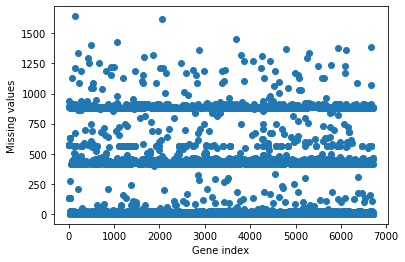

In [20]:
## plot the missing values per gene before filtering:
plt.scatter(range(full_table.shape[0]), row_nan_sums(full_table))
plt.xlabel('Gene index')
plt.ylabel('Missing values')
# plt.show()

In [21]:
## Define the threshold for genes removed from 'full_table':
k=round(0.1*full_table.shape[1]) #threshold
len(query_k_plus_sums(full_table,k)) #number of removed genes

2048

In [22]:
k #the threshold. genes that have more than k missing values will be removed. 

196

In [23]:
full_table.iloc[query_k_plus_sums(full_table,k)] ##removed genes

,gc_content_total,gc_content_1,gc_content_2,gc_content_3,molecular_weight,MeltingPoint_NN,aromaticity,isoelectric_point,helix_perc,turn_perc,...,AAU_neighbors_dist_target_gene_ks_dist,FE_neighbors_dist_target_gene_ks_dist,GC_neighbors_dist_target_gene_cart_d,CU_neighbors_dist_target_gene_cart_d,AAU_neighbors_dist_target_gene_cart_d,FE_neighbors_dist_target_gene_cart_d,GC_neighbors_dist_L1_dist,CU_neighbors_dist_L1_dist,AAU_neighbors_dist_L1_dist,FE_neighbors_dist_L1_dist
ORF,,,,,,,,,,,,,,,,,,,,,
Q0010,23.772610,22.480620,20.930233,27.906977,1.189251e+05,68.756624,0.271318,4.684387,0.689922,0.224806,...,0.285714,0.500000,1.099215,6.882708,0.054669,282.647998,1.437037,11.773242,0.716532,39.940000
Q0017,29.012346,35.185185,24.074074,27.777778,4.970086e+04,68.736876,0.129630,9.895935,0.518519,0.240741,...,0.285714,0.500000,0.983570,6.422266,0.053498,215.253997,1.557037,12.747872,0.735342,34.320000
Q0032,11.340206,9.278351,14.432990,10.309278,8.958672e+04,61.968730,0.247423,9.469543,0.649485,0.164948,...,0.285714,0.500000,1.146844,6.787585,0.054986,286.917998,1.320000,12.610575,0.704781,43.420000
Q0050,24.950100,30.898204,32.934132,11.017964,7.769448e+05,71.145017,0.082635,9.887512,0.361677,0.233533,...,0.190476,0.500000,1.047111,9.461169,0.055935,159.681998,1.473333,13.785043,0.461040,23.080000
Q0055,26.510721,31.111111,32.865497,15.555556,7.952377e+05,72.022549,0.092398,9.672668,0.347368,0.250292,...,0.190476,0.416667,1.079111,9.935381,0.056954,171.391998,1.366667,11.687849,0.470365,21.699999
Q0060,21.634615,30.528846,28.365385,6.009615,3.867137e+05,69.507854,0.112981,9.510803,0.379808,0.269231,...,0.190476,0.500000,0.976889,9.716674,0.056144,148.223998,1.606667,13.986812,0.483113,22.100000
Q0065,23.459007,30.879713,31.238779,8.258528,5.171934e+05,70.672292,0.107720,9.644348,0.402154,0.244165,...,0.190476,0.416667,0.999556,9.473032,0.056188,151.477998,1.553333,13.926882,0.511102,22.400000
Q0070,22.873745,30.269414,30.903328,7.448494,5.852550e+05,70.146024,0.118859,9.531433,0.440571,0.247227,...,0.238095,0.416667,0.954667,9.312675,0.057225,157.191997,1.693333,14.251699,0.475611,28.380000
Q0075,16.525822,26.760563,20.000000,2.816901,3.293122e+05,67.189685,0.146479,9.439270,0.445070,0.216901,...,0.190476,0.500000,1.392000,8.945132,0.058094,189.517999,0.780000,6.299912,0.336815,30.200000


In [24]:
## Remove from 'full_table' the genes with more than 25% missing values.
full_table.drop(full_table.iloc[query_k_plus_sums(full_table,k)].index,axis=0,inplace=True)

In [25]:
full_table

,gc_content_total,gc_content_1,gc_content_2,gc_content_3,molecular_weight,MeltingPoint_NN,aromaticity,isoelectric_point,helix_perc,turn_perc,...,AAU_neighbors_dist_target_gene_ks_dist,FE_neighbors_dist_target_gene_ks_dist,GC_neighbors_dist_target_gene_cart_d,CU_neighbors_dist_target_gene_cart_d,AAU_neighbors_dist_target_gene_cart_d,FE_neighbors_dist_target_gene_cart_d,GC_neighbors_dist_L1_dist,CU_neighbors_dist_L1_dist,AAU_neighbors_dist_L1_dist,FE_neighbors_dist_L1_dist
ORF,,,,,,,,,,,,,,,,,,,,,
Q0045,29.906542,38.130841,37.196262,14.392523,4.950959e+05,73.508043,0.127103,6.583801,0.431776,0.257944,...,0.142857,0.416667,1.075778,9.387726,0.056127,143.539998,1.400000,12.401977,0.441886,21.960000
Q0085,23.717949,28.461538,31.538462,11.153846,2.405752e+05,70.002141,0.130769,7.850525,0.507692,0.219231,...,0.142857,0.500000,1.526593,9.005698,0.056295,165.461997,0.808889,6.654022,0.398243,31.120000
Q0105,27.720207,36.010363,33.160622,13.989637,3.573327e+05,72.151406,0.147668,8.927429,0.471503,0.238342,...,0.190476,0.500000,1.443852,9.027811,0.056597,186.751998,0.827407,7.811413,0.320506,33.240000
Q0140,10.359231,13.283208,13.283208,4.511278,3.703925e+05,63.815998,0.082707,9.896179,0.393484,0.401003,...,0.142857,0.500000,1.738889,8.852762,0.056664,162.735999,0.693333,4.937459,0.364409,39.720000
Q0250,26.719577,40.873016,32.936508,6.349206,2.338840e+05,71.684708,0.103175,4.447083,0.408730,0.182540,...,0.142857,0.416667,1.286111,9.215504,0.055073,177.809997,0.945000,10.372980,0.368158,19.780000
Q0275,30.000000,40.370370,37.407407,12.222222,2.502091e+05,72.788495,0.114815,6.546570,0.422222,0.196296,...,0.142857,0.416667,1.090000,9.343439,0.056372,150.561998,1.380000,12.151960,0.449387,22.040000
YAL001C,37.123170,43.496985,34.366925,33.505599,1.081050e+06,77.211296,0.079242,9.379333,0.312661,0.217054,...,0.142857,0.500000,1.634889,9.296149,0.058466,167.527999,0.746667,3.884837,0.254581,26.520000
YAL002W,37.176471,42.431373,32.862745,36.235294,1.181424e+06,77.204045,0.096471,5.577209,0.367059,0.232157,...,0.238095,0.500000,1.489778,9.257618,0.059067,93.441998,0.660000,3.850903,0.313058,31.740000
YAL003W,44.605475,54.589372,35.265700,43.961353,1.919456e+05,80.195620,0.077295,4.295349,0.251208,0.159420,...,0.190476,0.583333,1.754000,9.442187,0.058730,270.115997,0.446667,11.469601,0.253966,35.500001


Text(0.5, 1.0, 'missing values per gene, after filtering the genes with more than 10% missing values')

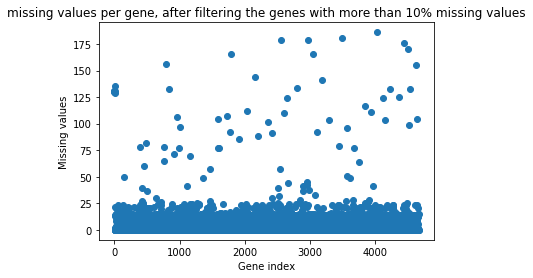

In [27]:
## plot the missing values per gene AFTER filtering:
plt.scatter(range(full_table.shape[0]), row_nan_sums(full_table))
plt.xlabel('Gene index')
plt.ylabel('Missing values')
plt.title('missing values per gene, after filtering the genes with more than 10% missing values')
# plt.show()

### Filter features with too many NaNs:

In [28]:
## create a list that specifices for each column in 'full_table' the number of NaNs:
nan_values = full_table.isnull().sum()
nan_values = nan_values.sort_values()
## create a list of features with the highest number of missing values:
highest_nan = nan_values[998:]
highest_nan.to_csv('highest_nans.csv')

/home/karinsio/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


Text(0.5, 1.0, 'missing values per feature')

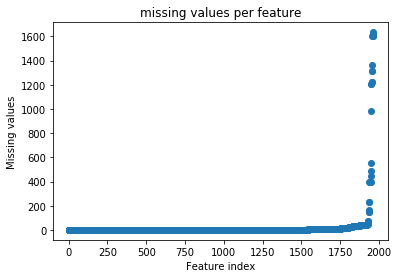

In [29]:
## plot the missing values per feature (before filtering the highest NaNs):
plt.scatter(range(len(nan_values.values)), nan_values.values)
plt.xlabel('Feature index')
plt.ylabel('Missing values')
plt.title('missing values per feature')
# plt.show()

In [30]:
## According to the plot above, The threshold is set to 600. 
# All features that have more than 600 missing values are to be removed from further analysis. 
filtered_features=highest_nan>600 #bool

In [31]:
indices = [i for i, x in enumerate(filtered_features) if x] ## get the indices of true values in 'filtered_features'
len(filtered_features[indices]) #number of filtered features

13

In [32]:
full_table.drop(list(filtered_features[indices].keys()),axis=1,inplace=True) ##drop those features

In [35]:
full_table

,gc_content_total,gc_content_1,gc_content_2,gc_content_3,molecular_weight,MeltingPoint_NN,aromaticity,isoelectric_point,helix_perc,turn_perc,...,AAU_neighbors_dist_target_gene_ks_dist,FE_neighbors_dist_target_gene_ks_dist,GC_neighbors_dist_target_gene_cart_d,CU_neighbors_dist_target_gene_cart_d,AAU_neighbors_dist_target_gene_cart_d,FE_neighbors_dist_target_gene_cart_d,GC_neighbors_dist_L1_dist,CU_neighbors_dist_L1_dist,AAU_neighbors_dist_L1_dist,FE_neighbors_dist_L1_dist
ORF,,,,,,,,,,,,,,,,,,,,,
Q0045,29.906542,38.130841,37.196262,14.392523,4.950959e+05,73.508043,0.127103,6.583801,0.431776,0.257944,...,0.142857,0.416667,1.075778,9.387726,0.056127,143.539998,1.400000,12.401977,0.441886,21.960000
Q0085,23.717949,28.461538,31.538462,11.153846,2.405752e+05,70.002141,0.130769,7.850525,0.507692,0.219231,...,0.142857,0.500000,1.526593,9.005698,0.056295,165.461997,0.808889,6.654022,0.398243,31.120000
Q0105,27.720207,36.010363,33.160622,13.989637,3.573327e+05,72.151406,0.147668,8.927429,0.471503,0.238342,...,0.190476,0.500000,1.443852,9.027811,0.056597,186.751998,0.827407,7.811413,0.320506,33.240000
Q0140,10.359231,13.283208,13.283208,4.511278,3.703925e+05,63.815998,0.082707,9.896179,0.393484,0.401003,...,0.142857,0.500000,1.738889,8.852762,0.056664,162.735999,0.693333,4.937459,0.364409,39.720000
Q0250,26.719577,40.873016,32.936508,6.349206,2.338840e+05,71.684708,0.103175,4.447083,0.408730,0.182540,...,0.142857,0.416667,1.286111,9.215504,0.055073,177.809997,0.945000,10.372980,0.368158,19.780000
Q0275,30.000000,40.370370,37.407407,12.222222,2.502091e+05,72.788495,0.114815,6.546570,0.422222,0.196296,...,0.142857,0.416667,1.090000,9.343439,0.056372,150.561998,1.380000,12.151960,0.449387,22.040000
YAL001C,37.123170,43.496985,34.366925,33.505599,1.081050e+06,77.211296,0.079242,9.379333,0.312661,0.217054,...,0.142857,0.500000,1.634889,9.296149,0.058466,167.527999,0.746667,3.884837,0.254581,26.520000
YAL002W,37.176471,42.431373,32.862745,36.235294,1.181424e+06,77.204045,0.096471,5.577209,0.367059,0.232157,...,0.238095,0.500000,1.489778,9.257618,0.059067,93.441998,0.660000,3.850903,0.313058,31.740000
YAL003W,44.605475,54.589372,35.265700,43.961353,1.919456e+05,80.195620,0.077295,4.295349,0.251208,0.159420,...,0.190476,0.583333,1.754000,9.442187,0.058730,270.115997,0.446667,11.469601,0.253966,35.500001


Text(0.5, 1.0, 'missing values per feature, after filtering the features with the highest number of missing values')

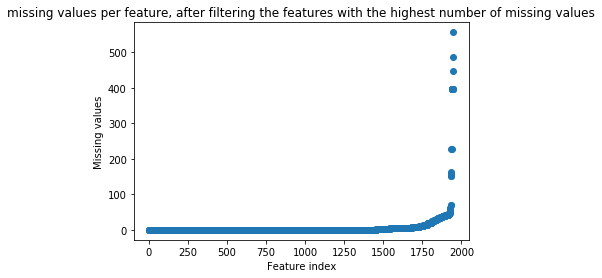

In [36]:
## plot the missing values per feature AFTER filtering the highest NaNs:
nan_values = full_table.isnull().sum()
nan_values = nan_values.sort_values()
plt.scatter(range(len(nan_values.values)), nan_values.values)
plt.xlabel('Feature index')
plt.ylabel('Missing values')
plt.title('missing values per feature, after filtering the features with the highest number of missing values')
# plt.show()

## Normalize the table:

In [37]:
normalized_table = full_table.copy()

In [38]:
# Creating not normalized table with the median value in NaN's places
full_table_not_normalized = full_table.fillna(full_table.median())

In [39]:
# Checking if there is object type columns
filter_str_columns = normalized_table.dtypes[normalized_table.dtypes == np.object]
listOfColumnNames = list(filter_str_columns.index)
 
print(listOfColumnNames)

[]


In [40]:
# creating numerical table
numerical_cols = [col for col in normalized_table.columns if (col is not 'ORF')]
numerical_table = normalized_table[numerical_cols]

In [41]:
numerical_normalize_table = (numerical_table-numerical_table.mean())/numerical_table.std() 
        
### fill column with mean values
numerical_normalize_table = numerical_normalize_table.fillna(numerical_normalize_table.mean())


In [42]:
numerical_normalize_table

,gc_content_total,gc_content_1,gc_content_2,gc_content_3,molecular_weight,MeltingPoint_NN,aromaticity,isoelectric_point,helix_perc,turn_perc,...,AAU_neighbors_dist_target_gene_ks_dist,FE_neighbors_dist_target_gene_ks_dist,GC_neighbors_dist_target_gene_cart_d,CU_neighbors_dist_target_gene_cart_d,AAU_neighbors_dist_target_gene_cart_d,FE_neighbors_dist_target_gene_cart_d,GC_neighbors_dist_L1_dist,CU_neighbors_dist_L1_dist,AAU_neighbors_dist_L1_dist,FE_neighbors_dist_L1_dist
ORF,,,,,,,,,,,,,,,,,,,,,
Q0045,-2.866289,-1.442111,0.197998,-3.863215,0.084135,-2.914669,1.425618,-0.265794,2.377942,0.440224,...,-0.527854,-2.714407,-6.612752,1.026463,-1.509626,-0.913607,6.829526,3.655271,2.555937,-2.203560
Q0085,-4.610954,-3.480460,-0.884831,-4.369862,-0.666915,-5.125692,1.556033,0.421240,3.780023,-0.430751,...,-0.527854,-0.131235,-1.503235,-0.355071,-1.360954,-0.237426,1.283119,0.803467,1.719627,-0.334141
Q0105,-3.482652,-1.889121,-0.574371,-3.926241,-0.322383,-3.770243,2.157138,1.005320,3.111646,-0.000784,...,0.749345,-0.131235,-2.441015,-0.275103,-1.094325,0.419261,1.456879,1.377698,0.229950,0.098519
Q0140,-8.376993,-6.680146,-4.378649,-5.409001,-0.283845,-9.027028,-0.153551,1.530742,1.670738,3.658779,...,-0.527854,-0.131235,0.902923,-0.908137,-1.034476,-0.321509,0.198859,-0.048193,1.071273,1.420990
Q0250,-3.764746,-0.864044,-0.617263,-5.121482,-0.686660,-4.064569,0.574491,-1.424687,1.952321,-1.256233,...,-0.527854,-2.714407,-4.228842,0.403655,-2.441099,0.143446,2.560253,2.648600,1.143113,-2.648465
Q0275,-2.839942,-0.970005,0.238409,-4.202729,-0.638487,-3.368458,0.988534,-0.285987,2.201501,-0.946734,...,-0.527854,-2.714407,-6.451558,0.866307,-1.292777,-0.697015,6.641866,3.531227,2.699687,-2.187233
YAL001C,-0.831805,-0.310895,-0.343500,-0.873233,1.813190,-0.579186,-0.276792,1.250420,0.178057,-0.479718,...,-0.527854,-0.131235,-0.275809,0.695291,0.558396,-0.173701,0.699287,-0.570443,-1.033349,-1.272932
YAL002W,-0.816778,-0.535533,-0.631381,-0.446209,2.109379,-0.583759,0.336029,-0.811739,1.182705,-0.139937,...,2.026545,-0.131235,-1.920492,0.555951,1.089490,-2.458874,-0.113908,-0.587279,0.087224,-0.207609
YAL003W,1.277579,2.027448,-0.171486,0.762428,-0.810413,1.302900,-0.346059,-1.506982,-0.956914,-1.776376,...,0.749345,2.451937,1.074192,1.223414,0.791858,2.990613,-2.115619,3.192680,-1.045142,0.559751


In [43]:
full_table_not_normalized.to_csv('updated_new_features_table.csv')
numerical_normalize_table.to_csv('normalized_updated_new_features_table.csv')